# TextGrad Tutorials: MultiModal Optimization

![TextGrad](https://github.com/vinid/data/blob/master/logo_full.png?raw=true)

An autograd engine -- for textual gradients!

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/zou-group/TextGrad/blob/main/examples/notebooks/Prompt-Optimization.ipynb)
[![GitHub license](https://img.shields.io/badge/License-MIT-blue.svg)](https://lbesson.mit-license.org/)
[![Arxiv](https://img.shields.io/badge/arXiv-2406.07496-B31B1B.svg)](https://arxiv.org/abs/2406.07496)
[![Documentation Status](https://readthedocs.org/projects/textgrad/badge/?version=latest)](https://textgrad.readthedocs.io/en/latest/?badge=latest)
[![PyPI - Python Version](https://img.shields.io/pypi/pyversions/textgrad)](https://pypi.org/project/textgrad/)
[![PyPI](https://img.shields.io/pypi/v/textgrad)](https://pypi.org/project/textgrad/)

**Objectives for this tutorial:**

* Explore some more MultiModal cases in TextGrad. Using a dataset from the literature.

**Requirements:**

* You need to have an OpenAI API key to run this tutorial. This should be set as an environment variable as OPENAI_API_KEY.


## Image Support in TextGrad

We currently supports PNG and JPEG images. We have a few examples below to show how to use images in TextGrad. If your image is in a different format you should convert it. Here is an example function that 
does that for you. 

The way we support images is through the byte format. This is then converted to a Base64 string and sent to the OpenAI/Anthropic API.

In [1]:
# Some utils to read images

import io
from PIL import Image

# 
def encode_image(image):
    # Convert RGBA to RGB if necessary
    if image.mode == 'RGBA':
        # Create a new image with a white background
        background = Image.new('RGB', image.size, (255, 255, 255))
        # Paste the image on the background.
        background.paste(image, (0, 0), image)
        image = background

    # Create a BytesIO object
    buffered = io.BytesIO()

    # Save your image object to this BytesIO object (in JPEG format)
    image.save(buffered, format="JPEG")

    # Get the byte data from the BytesIO object
    image_byte_data = buffered.getvalue()
    return image_byte_data

In [1]:
import textgrad as tg

# differently from the past tutorials, we now need a multimodal LLM call instead of a standard one!
from textgrad.autograd import MultimodalLLMCall
from textgrad.loss import ImageQALoss
from datasets import load_dataset


In [3]:
from dotenv import load_dotenv
load_dotenv(".env", override=True)

True

In [36]:
tg.set_backward_engine("gpt-4o", override=True)

In [37]:
ds = load_dataset("derek-thomas/ScienceQA")

In [62]:
target_image = ds["train"][10]["image"]
target_question = ds["train"]["question"][10]
target_options = ds["train"]["choices"][10]
target_options = "\n-".join(target_options)
target_correct_answer = ds["train"]["answer"][10]

question_for_model = f"{target_question}\n\n-{target_options}"
print(question_for_model)

Which solution has a higher concentration of blue particles?

-neither; their concentrations are the same
-Solution B
-Solution A


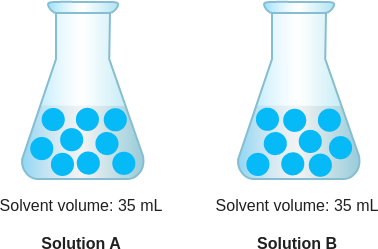

In [63]:
target_image

In [69]:
target_image = encode_image(target_image)

image_variable = tg.Variable(target_image, role_description="image to answer a question about", requires_grad=False)

In [70]:
question_variable = tg.Variable(question_for_model, role_description="question to answer", requires_grad=False)
response = MultimodalLLMCall("gpt-4o")([image_variable, question_variable])
response

Variable(value=Solution B has a higher concentration of blue particles. Both solutions have the same solvent volume (35 mL), but Solution B contains more blue particles than Solution A., role=response from the language model, grads=set())

In [71]:
loss_fn = ImageQALoss(
    evaluation_instruction="Please evaluate the existing answer to the visual scientific problem without solving it yourself. Verify that the answer accurately understands the image, provides appropriate knowledge and reasoning logic to address the question.",
    engine="gpt-4o"
)
loss = loss_fn(question=question_variable, image=image_variable, response=response)
loss

Variable(value=The existing answer correctly identifies that Solution B has a higher concentration of blue particles. The reasoning provided is accurate: both solutions have the same solvent volume (35 mL), but Solution B contains more blue particles than Solution A. This indicates a higher concentration of blue particles in Solution B. The answer accurately understands the image and provides appropriate knowledge and reasoning logic to address the question., role=evaluation of the response from the language model, grads=set())

### Direct PNG

In [27]:
import httpx

image_url = "https://d2bzx2vuetkzse.cloudfront.net/fit-in/0x450/images_without_background/45ca6024-4bf0-43b8-9a3a-b4a44ecac0bf.png"
image_data = httpx.get(image_url).content

In [30]:
image_variable = tg.Variable(image_data, role_description="image to answer a question about", requires_grad=False)

In [31]:
question_variable = tg.Variable("What do you see in this image?", role_description="question", requires_grad=False)
response = MultimodalLLMCall("gpt-4o")([image_variable, question_variable])
response

Variable(value=The image shows a small, brown rodent that appears to be a capybara. Capybaras are the largest rodents in the world and are native to South America. They have a distinctive appearance with a large, barrel-shaped body, short legs, and a blunt snout. This particular capybara is sitting and facing to the right., role=response from the language model, grads=set())